In [8]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import lightgbm
import category_encoders
import missingno
import boruta
import tsfresh
import sktime
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import shap
import re
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    fbeta_score,
    cohen_kappa_score,
    make_scorer, 
    fbeta_score
)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import KNNImputer, SimpleImputer


In [2]:
features_wide = pd.read_csv("C:/Users/u840716/Anna Thesis/Code Files -/Models/ML_models/summary_features_wide_final_2.csv")

### Evaluation function

In [3]:
def evaluate_model(model, X_test, y_test, model_name="Model", save_fig=False):
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Basic Metrics
    cm = confusion_matrix(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Evaluation for {model_name}")
    print("-" * 40)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F2 Score: {f2:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Plotting
    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"])
    plt.yticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"], rotation=0)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{model_name.replace(' ', '_')}_evaluation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [4]:
X = features_wide.drop(columns=["PatID", "Patient_Type"])
y = features_wide["Patient_Type"]

Split by vt and control for imputation

In [5]:
# 1. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 2. Split by class
X_vt_train = X_train[y_train == 1]
X_control_train = X_train[y_train == 0]
X_vt_test = X_test[y_test == 1]
X_control_test = X_test[y_test == 0]

## Imputation

In [6]:
def impute_and_evaluate_logreg(imputer_vt, imputer_control, name):
    X_vt_train_imputed = pd.DataFrame(imputer_vt.fit_transform(X_vt_train), columns=X.columns)
    X_control_train_imputed = pd.DataFrame(imputer_control.fit_transform(X_control_train), columns=X.columns)

    X_vt_test_imputed = pd.DataFrame(imputer_vt.transform(X_vt_test), columns=X.columns)
    X_control_test_imputed = pd.DataFrame(imputer_control.transform(X_control_test), columns=X.columns)

    X_train_final = pd.concat([X_vt_train_imputed, X_control_train_imputed])
    y_train_final = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

    X_test_final = pd.concat([X_vt_test_imputed, X_control_test_imputed])
    y_test_final = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])


    model = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)
    model.fit(X_train_final, y_train_final)

    evaluate_model(model, X_test_final, y_test_final, model_name=f"Logistic Regression - {name}")

Apply different imputation methods

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation for Logistic Regression - Mean Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       397
           1       0.27      0.34      0.30        29

    accuracy                           0.89       426
   macro avg       0.61      0.64      0.62       426
weighted avg       0.90      0.89      0.90       426

F2 Score: 0.3268
Cohen’s Kappa: 0.2454
ROC AUC Score: 0.8298
----------------------------------------


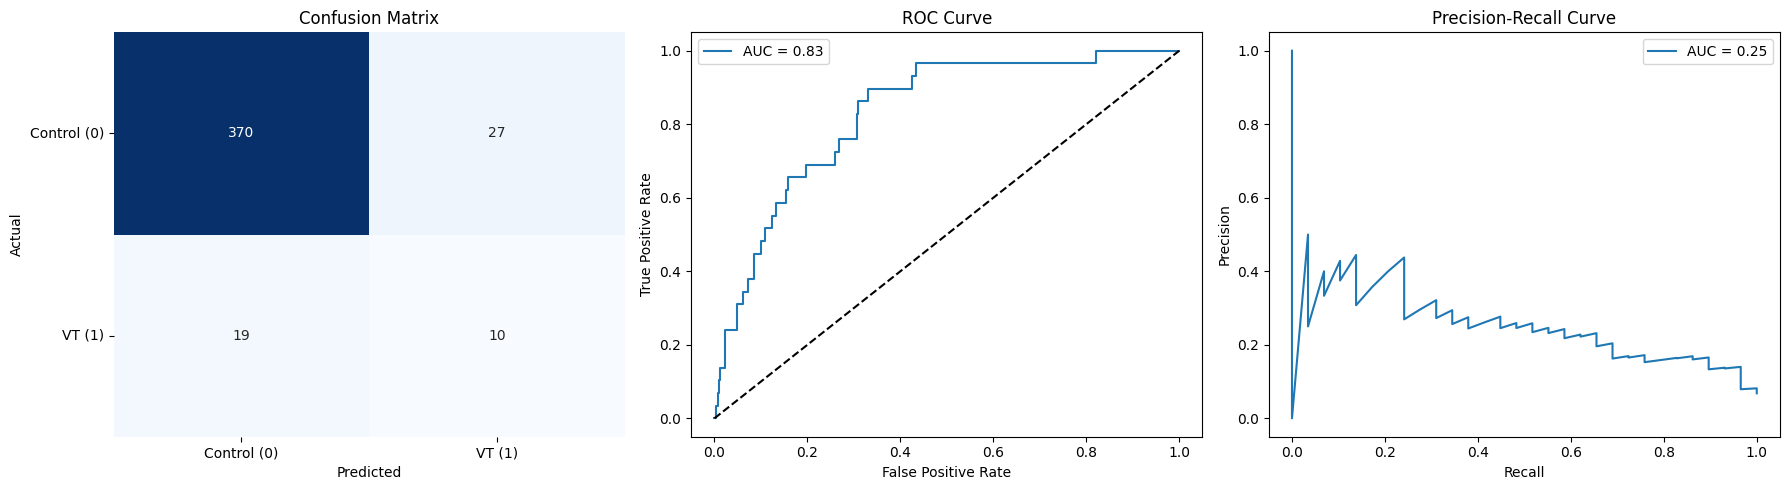

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation for Logistic Regression - Median Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       397
           1       0.37      0.38      0.37        29

    accuracy                           0.91       426
   macro avg       0.66      0.67      0.66       426
weighted avg       0.91      0.91      0.91       426

F2 Score: 0.3767
Cohen’s Kappa: 0.3262
ROC AUC Score: 0.7973
----------------------------------------


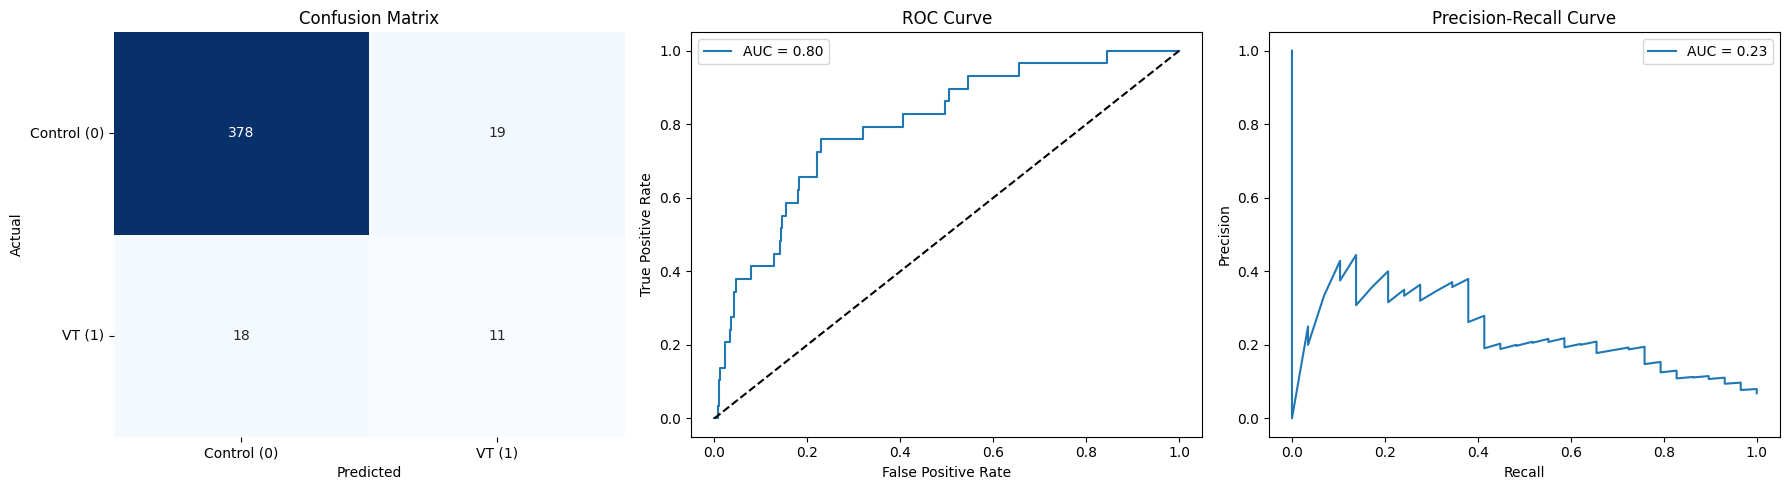

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation for Logistic Regression - KNN Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       397
           1       0.26      0.31      0.28        29

    accuracy                           0.89       426
   macro avg       0.60      0.62      0.61       426
weighted avg       0.90      0.89      0.90       426

F2 Score: 0.2980
Cohen’s Kappa: 0.2234
ROC AUC Score: 0.7775
----------------------------------------


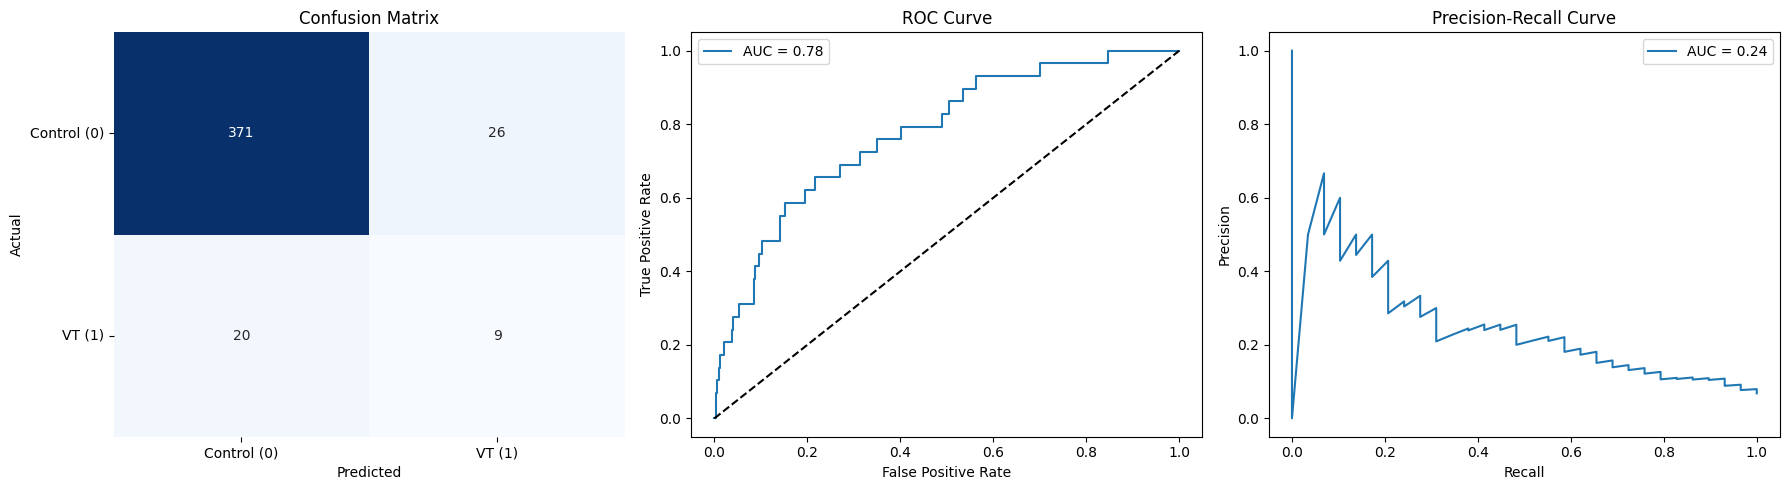

In [7]:
mean_vt = SimpleImputer(strategy='mean')
mean_control = SimpleImputer(strategy='mean')
impute_and_evaluate_logreg(mean_vt, mean_control, "Mean Imputation (per class)")

median_vt = SimpleImputer(strategy='median')
median_control = SimpleImputer(strategy='median')
impute_and_evaluate_logreg(median_vt, median_control, "Median Imputation (per class)")

knn_vt = KNNImputer(n_neighbors=5)
knn_control = KNNImputer(n_neighbors=5)
impute_and_evaluate_logreg(knn_vt, knn_control, "KNN Imputation (per class)")

median performs best

In [11]:
# Impute Train Set
X_vt_train_imputed = pd.DataFrame(median_vt.fit_transform(X_vt_train), columns=X.columns)
X_control_train_imputed = pd.DataFrame(median_control.fit_transform(X_control_train), columns=X.columns)
X_train_median = pd.concat([X_vt_train_imputed, X_control_train_imputed])
y_train_median = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

# Impute Test Set using train imputers
X_vt_test_imputed = pd.DataFrame(median_vt.transform(X_vt_test), columns=X.columns)
X_control_test_imputed = pd.DataFrame(median_control.transform(X_control_test), columns=X.columns)
X_test_median = pd.concat([X_vt_test_imputed, X_control_test_imputed])
y_test_median = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])

# Shuffle training data
X_train_median, y_train_median = shuffle(X_train_median, y_train_median, random_state=42)



## Oversampling

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation for LR - Median Imputation + ADASYN
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       397
           1       0.25      0.45      0.32        29

    accuracy                           0.87       426
   macro avg       0.60      0.67      0.62       426
weighted avg       0.91      0.87      0.89       426

F2 Score: 0.3846
Cohen’s Kappa: 0.2512
ROC AUC Score: 0.7580
----------------------------------------


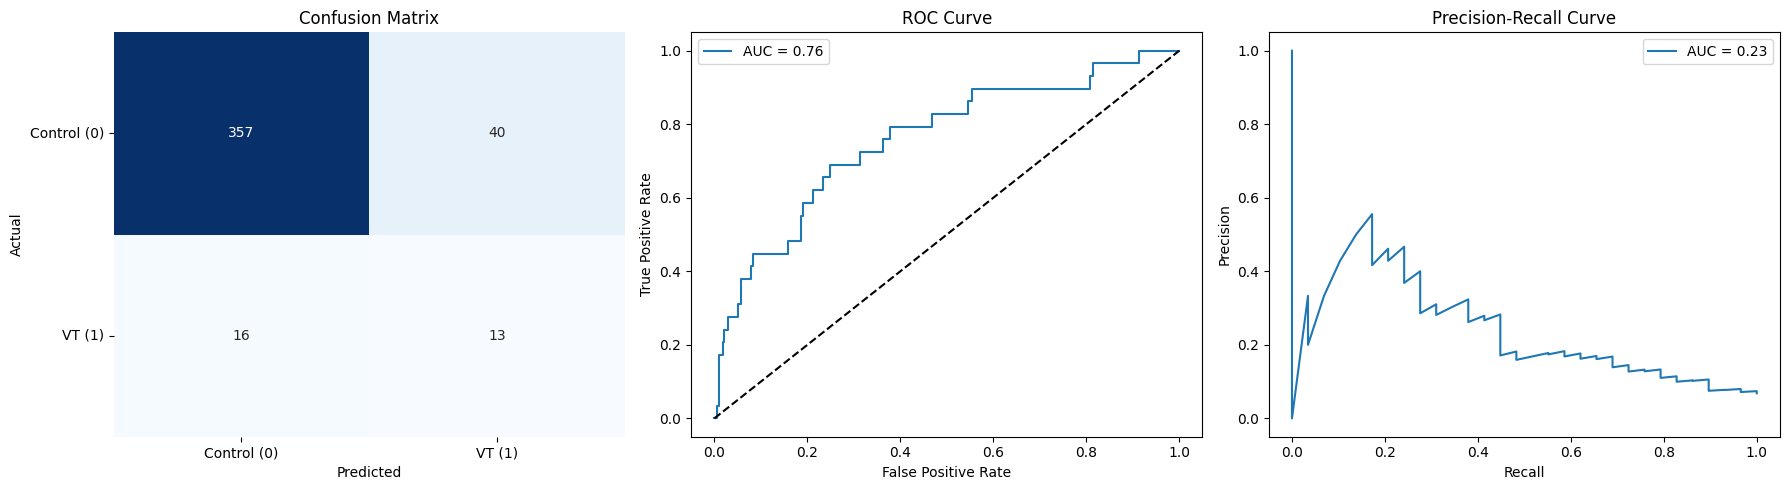

c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation for LR - Median Imputation + SMOTE
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       397
           1       0.22      0.45      0.30        29

    accuracy                           0.86       426
   macro avg       0.59      0.67      0.61       426
weighted avg       0.91      0.86      0.88       426

F2 Score: 0.3736
Cohen’s Kappa: 0.2289
ROC AUC Score: 0.7791
----------------------------------------


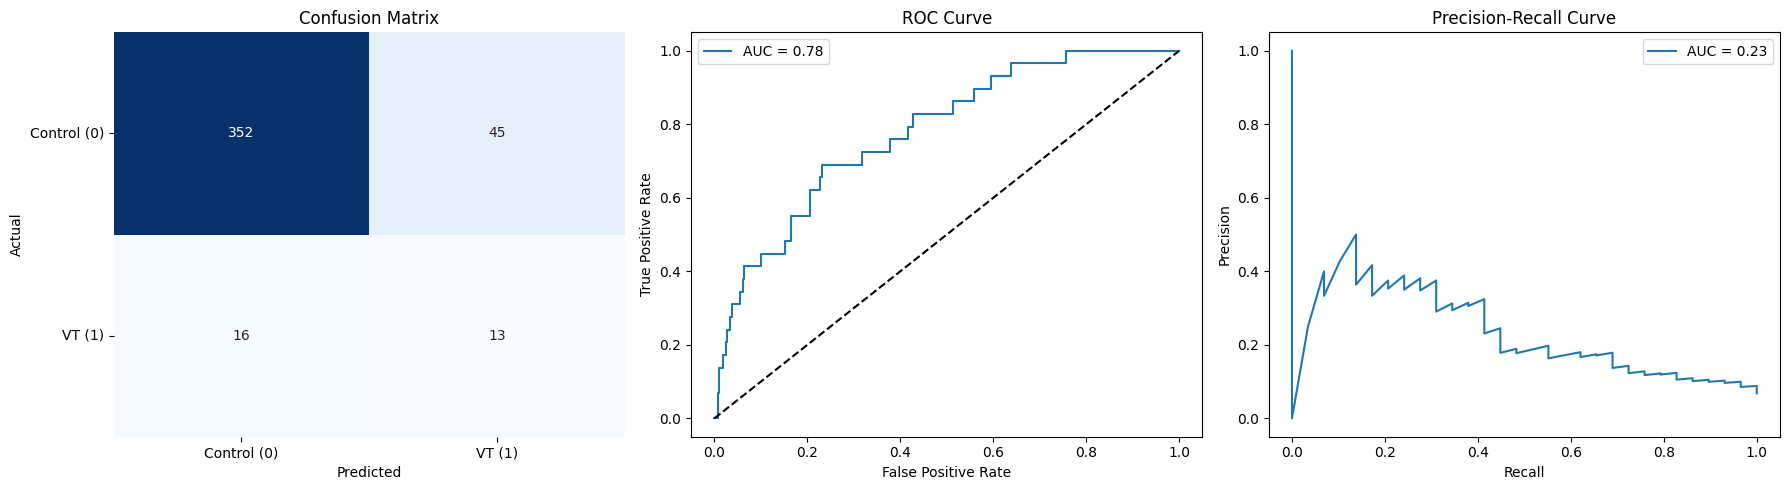

In [ ]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_median)
X_test_scaled = scaler.transform(X_test_median)


adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42)

# Apply ADASYN
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_median, y_train_median)
model_adasyn = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)
model_adasyn.fit(X_train_adasyn, y_train_adasyn)
evaluate_model(model_adasyn, X_test_median, y_test_median, model_name="LR - Median Imputation + ADASYN", save_fig=True)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_median, y_train_median)
model_smote = LogisticRegression(max_iter=5000, solver="lbfgs", random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
evaluate_model(model_smote, X_test_median, y_test_median, model_name="LR - Median Imputation + SMOTE", save_fig=True)

Both models perform similarly, but ADASYN is slightly better


# Hyperparameter tuning

Using GridSearch (CV), performs much worse

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Evaluation for Tuned Logistic Regression + ADASYN
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.49      0.65       397
           1       0.09      0.72      0.17        29

    accuracy                           0.51       426
   macro avg       0.53      0.61      0.41       426
weighted avg       0.90      0.51      0.62       426

F2 Score: 0.3107
Cohen’s Kappa: 0.0533
ROC AUC Score: 0.5830
----------------------------------------


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


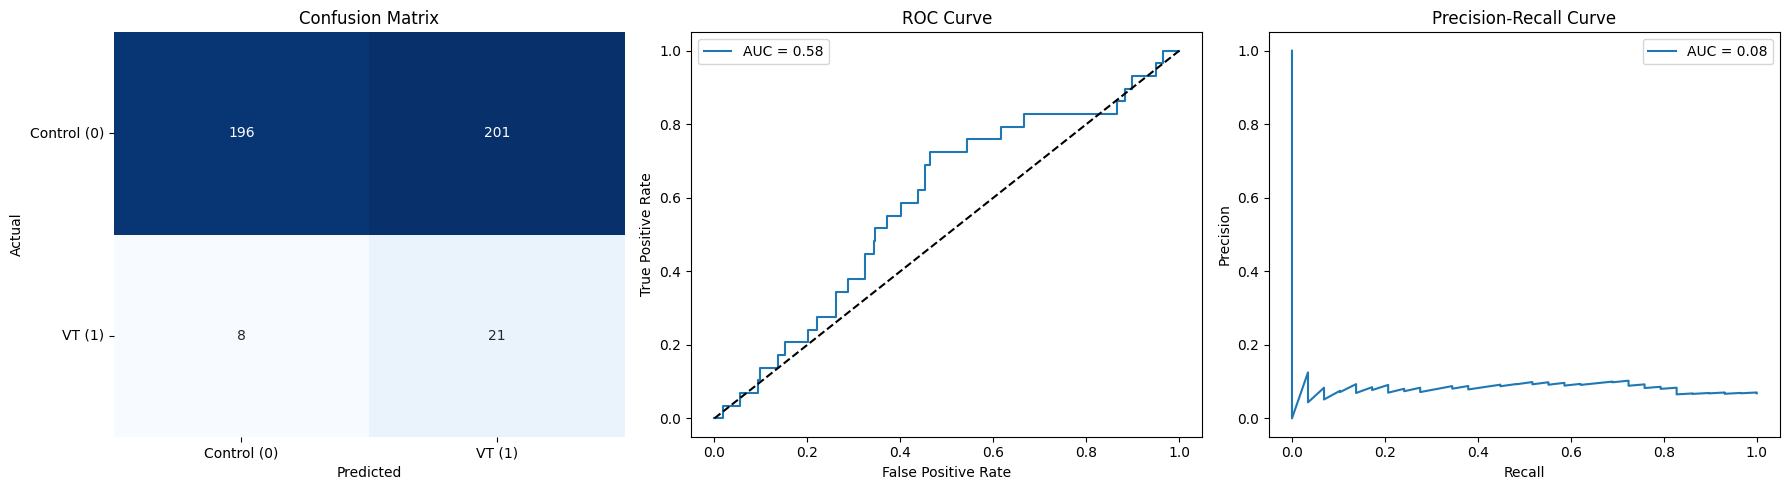

In [ ]:
# Define the F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

#  param grid
param_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"],
    "max_iter": [500, 1000]
}

# Set up grid search
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=2
)

# StratifiedKFold for class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model
lr = LogisticRegression()

grid.fit(X_train_adasyn, y_train_adasyn)

# Best model
best_lr = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate on test set
evaluate_model(best_lr, X_test_scaled, y_test_median, model_name="Tuned Logistic Regression + ADASYN")


Second attempt, even worse

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\u840716\Anna Thesis\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Best parameters: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Evaluation for Tuned Logistic Regression + ADASYN
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.51      0.66       397
           1       0.08      0.62      0.15        29

    accuracy                           0.52       426
   macro avg       0.52      0.56      0.41       426
weighted avg       0.89      0.52      0.63       426

F2 Score: 0.2736
Cohen’s Kappa: 0.0329
ROC AUC Score: 0.5839
----------------------------------------


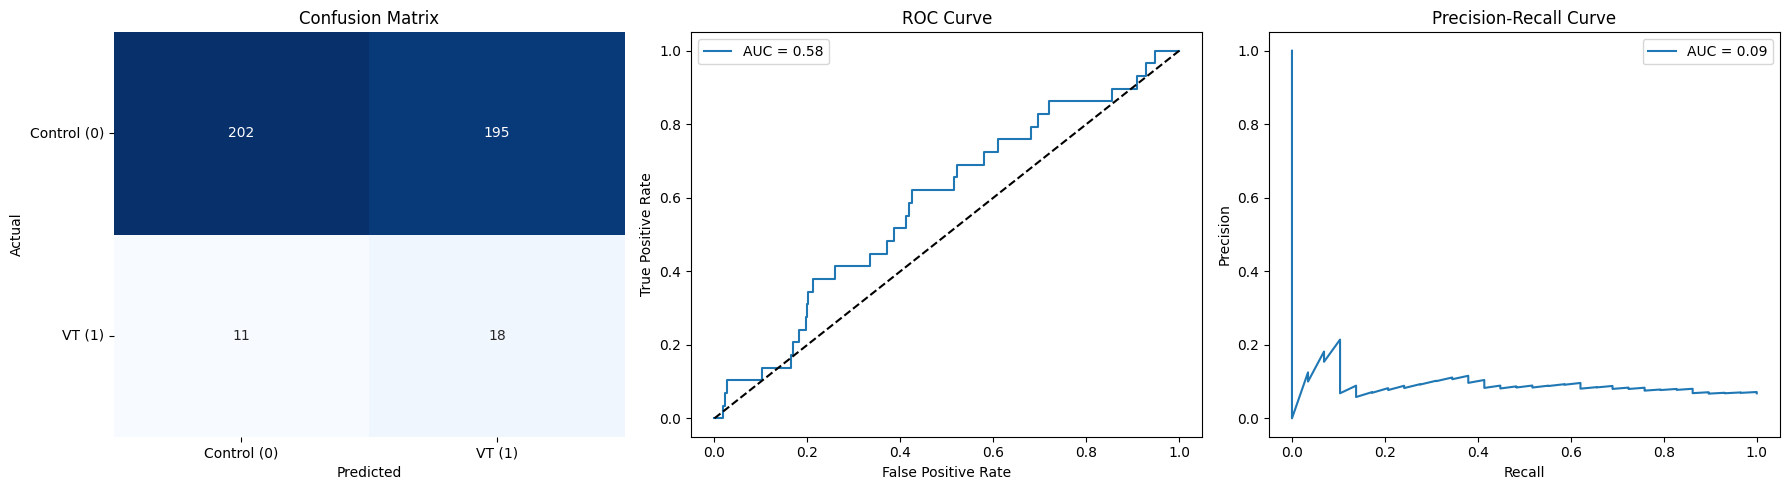

In [ ]:
# Define the F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# Param grid
param_grid = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "saga"],
    "max_iter": [500, 1000, 5000, 10000]
}

# Grid search
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=2
)

# StratifiedKFold for class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model
lr = LogisticRegression()


# Fit on the resampled training set
grid.fit(X_train_adasyn, y_train_adasyn)

# Best model
best_lr = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate on test set
evaluate_model(best_lr, X_test_scaled, y_test_median, model_name="Tuned Logistic Regression + ADASYN")